# **Modelos de clasificación - Grupo03**

## **Authors**

- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310



## **Repositorio**

Esta práctica se ha llevado a cabo en este [repositorio de github](https://github.com/CLopMan/aprendizajeAutomatico-G03)

## **Introducción**

En este cuaderno se resolverá un problema similar. Las instancias de energía se han clasificado en "low" o "high" según si su valor es inferior o superior al valor del tercer cuartil. En este cuaderno trataremos de entrenar un modelo capaz de clasificar nuevas instancias en estas clases.

# **1. Transformación de datos**

El primer paso para el problema de clasificación es aplicar una transformación a la variable de salida. Es por ello que calculamos el tercer cuantil y transformamos la variable de salida respecto a este.  

In [34]:
#from google.colab import drive
#drive.mount('/content/drive')

In [35]:
import pandas as pd

#raw_data = pd.read_csv("/content/drive/MyDrive/wind_ava.csv") # cambiar para la entrega final
raw_data = pd.read_csv("wind_ava.csv.gz", compression='gzip')
sotavento = raw_data.filter(regex='13$|energy|datetime') # eliminacion de instancias no referentes a Sotavento

Q3 = sotavento["energy"].quantile(0.75)
sotavento.insert(1, "energyTag", ["high" for i in range(len(sotavento))])

def myfunc(v):
    if v < Q3:
        return "low"
    else:
        return "high"

cont = 0
for i, v in enumerate(sotavento["energy"]):
    if v < Q3:
        sotavento.loc[i, "energyTag"] = "low"
        cont += 1

sotavento = sotavento.drop("energy", axis=1)

# **2. Clases desbalanceadas**

Si observamos los valores de energyTag, la nueva columna del dataframe que indica la clase de cada instancia, podemos ver que las clases están desbalanceadas.


Número de instancias 'low': 3561
Número de instancias 'high':1187


<Axes: ylabel='count'>

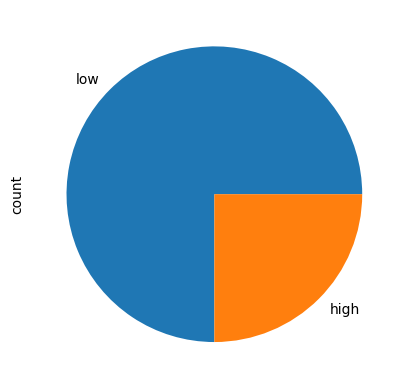

In [36]:
print(f"Número de instancias \'low\': {cont}\nNúmero de instancias \'high\':{len(sotavento) - cont}")

sotavento["energyTag"].value_counts().plot(kind="pie")

## **2.1. División entre train y test**
Para poder balancear las clases, primero necesitaremos dividir, entre train y test los datos.


In [37]:
from sklearn.model_selection import train_test_split

size = 0

res = pd.to_datetime(sotavento["datetime"], unit='ns').astype(str)

for ind, data in res.items():
  if data.startswith("2008") or data.startswith("2009"):
    size += 1

print("Hay", str(size), "instancias de 2008 y 2009")

# Se obtienen los datos
X = sotavento.drop(["energyTag", "datetime"], axis="columns")
Y = sotavento[["energyTag"]]

train, test = train_test_split(sotavento, test_size=size, shuffle=False)

X_train = train.drop(["energyTag", "datetime"], axis="columns")
Y_train = train[["energyTag"]]
X_test = test.drop(["energyTag", "datetime"], axis="columns")
Y_test = test[["energyTag"]]

Hay 1099 instancias de 2008 y 2009


## **2.2- SMOTE**

Debido al desbalanceo entre clases, es necesario utilizar algún mecanismo para evitar que el modelo final esté sesgado.


Despues de SMOTE, la forma de train_X: (5492, 22)
Después de SMOTE, la forma de train_y: (5492, 1) 



<Axes: ylabel='count'>

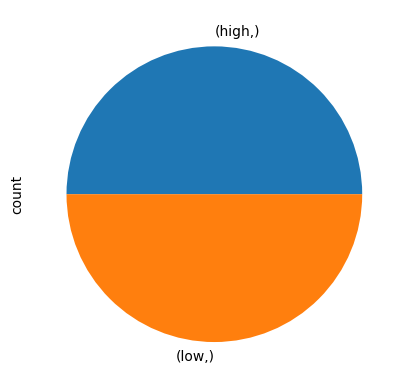

In [38]:
#from imblearn.over_sampling import SMOTE
#
#sm = SMOTE(random_state = 100472310)
#X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)
#
#print('Despues de SMOTE, la forma de train_X: {}'.format(X_train_res.shape))
#print('Después de SMOTE, la forma de train_y: {} \n'.format(Y_train_res.shape))
#
#Y_train_res.value_counts().plot(kind="pie")

# **3. Evaluación del modelo**
Para poder realizar modelos de clasificación, es necesario clarificar las métricas que usaremos para la evaluación inner y la evaluación outer.

## **3.1 Evaluación Inner**

Utilizaremos validación cruzada con k = 3 para la evaluación inner. Descartamos usar time series split debido a la nueva naturaleza del problema.

## **3.2 Evaluación Outer**
Para la evaluación outer, haremos un split dejando 2007 y 2008 para evaluar y el resto de años para entrenar.

## **3.3 Métricas de evaluación**

Para evaluar el modelo, utilizaremos la métrica de F1-score debido a que se trata de un problema con clases desbalanceadas. Esta métrica no es sensible al desequilibrio de clases.



# **4. Modelos de clasificación**
En este apartado, haremos HPO con los 4 métodos, que hemos usado en el apartado anterior, comparando finalmente los modelos para elegir el mejor.

## **4.1. K-folds**
Lo primero que deberemos hacer es dividir las partes inner del problema, creando el objeto de K-folds.

In [39]:
from sklearn.model_selection import KFold

kfold = KFold(3)
f1_score = {}
train_time = {}

## **4.2. KNN**

In [45]:
# Knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from time import time


pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('knn', KNeighborsClassifier())
      ])

# Se crean los parametros
param_grid = {"knn__n_neighbors": list(range(10, 40, 1)),
              "knn__weights": ["uniform", "distance"],
              "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "knn__metric": ["euclidean", "manhattan", "chebyshev"]
              }

# Se realiza la HPO
grid = GridSearchCV(pipe,
                    param_grid,
                    cv=kfold,
                    scoring="f1_weighted",
                    verbose=1,
                    n_jobs=-1)
start = time()
grid.fit(X_train, Y_train.values.ravel())
end = time()

print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")



f1_score["knn"] = grid.best_score_

print(f"f1-score: {grid.best_score_}")
print("Tiempo de entrenamiento:", str(round(end-start, 2)) + "s.")
train_time["knn"] = end - start

Fitting 3 folds for each of 720 candidates, totalling 2160 fits

Los mejores parámetros son:
 {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 22, 'knn__weights': 'uniform'} 

f1-score: 0.8448799536945174
Tiempo de entrenamiento: 29.31s.


## **4.4 SVM**
Usaremos un SVM para este apartado. De la misma manera que con el SVR, haremos la evaluación con tres modelos distintos, uno con cada tipo de kernel, para evitar combinaciones innecesarias y así ahorra tiempo de entrenamiento.

In [46]:
from sklearn.svm import SVC

kernels = ["linear", "poly", "rbf"]

# Hiperparámetros kernel lineal
param_grid_linear = {
              "svm__C": [1, 10, 100],
              "svm__class_weight":[None, "balanced"]
              }

# Hiperparámetros kernel poly
param_grid_poly = {
              "svm__C": [1, 10, 100],
              "svm__degree": list(range(1,4,1)),
              "svm__gamma": ["scale", "auto"],
              "svm__coef0": [0.0, 0.1],
              "svm__class_weight":[None, "balanced"]
              }

# Hiperparámetros kernel rbf
param_grid_rbf = {
              "svm__C": [1, 10, 100],
              "svm__gamma": ["scale", "auto"],
              "svm__class_weight":[None, "balanced"]
              }

for k in kernels:
  print("==========Kernel", k + "==========")

  # Se crea el regresor con kernel
  svm = SVC(kernel=k)

  # Se crea la pipeline
  pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm)
        ])

  # Se realiza la HPO
  match(k):
    case "linear":
      param_grid = param_grid_linear

    case "poly":
      param_grid = param_grid_poly

    case "rbf":
      param_grid = param_grid_rbf

  grid = GridSearchCV(pipe,
                      param_grid,
                      cv=kfold,
                      scoring="f1_weighted",
                      verbose=1,
                      n_jobs=-1)

  start = time()
  grid.fit(X_train, Y_train.values.ravel())
  end = time()

  print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")

  # Se obtiene el f1 del mejor modelo
  f1 = grid.best_score_

  f1_score["svm_"+k] = grid.best_score_
  print("F1_score:", str(f1))
  print("Tiempo de entrenamiento:", str(round(end-start,2)) + "s.")
  train_time["svm_"+k] = end - start

==========Kernel linear==========
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Los mejores parámetros son:
 {'svm__C': 100, 'svm__class_weight': None} 

F1_score: 0.8031698686574388
Tiempo de entrenamiento: 18.07s.
==========Kernel poly==========
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Los mejores parámetros son:
 {'svm__C': 100, 'svm__class_weight': None, 'svm__coef0': 0.0, 'svm__degree': 2, 'svm__gamma': 'scale'} 

F1_score: 0.8646910548389238
Tiempo de entrenamiento: 9.33s.
==========Kernel rbf==========
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Los mejores parámetros son:
 {'svm__C': 1, 'svm__class_weight': None, 'svm__gamma': 'scale'} 

F1_score: 0.8576849811533821
Tiempo de entrenamiento: 1.2s.


# Árbol de decisión 

In [48]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

np.random.seed(100472092)
# Espacio de búsqueda

param_grid = {'max_depth': list(range(2, 24, 1)),
              'min_samples_split':list(range(30, 101, 3)), 
              "criterion": ["gini", "entropy", "log_loss"],
              "splitter": ["best", "random"], 
              "class_weight": ["balanced", None]}

grid = GridSearchCV(DecisionTreeClassifier(),
                         param_grid,
                         scoring='f1_weighted',
                         cv=kfold,
                         n_jobs=-1,
                         verbose=1)

start = time()
grid.fit(X=X_train, y=Y_train)
end = time()

print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")

f1_score["tree"] = grid.best_score_

print("f1:", str(grid.best_score_))
print("Tiempo de ejecución:", str(round(end - start, 2)) + "s.")
train_time["tree"] = end - start 

Fitting 3 folds for each of 6336 candidates, totalling 19008 fits



Los mejores parámetros son:
 {'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 75, 'splitter': 'best'} 

f1: 0.8656129127756959
Tiempo de ejecución: 87.73s.


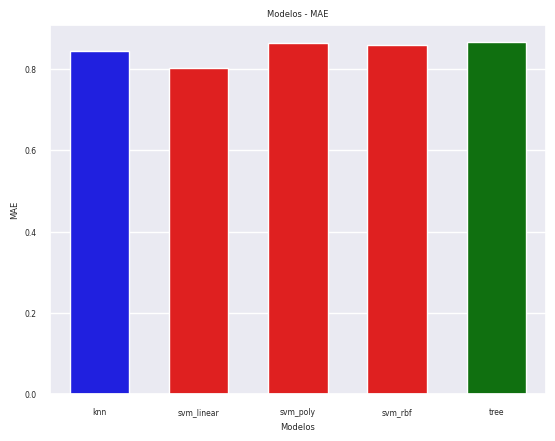

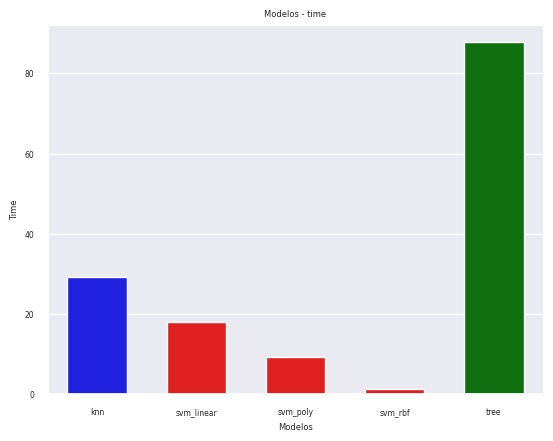

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
# Colores del diagrama
colores = ["blue", "red", "red", "red", "green"]
sns.set(font_scale=0.5)

# Valores del mae
titulos_mae = f1_score.keys()
valores_mae = f1_score.values()
titulos_time = train_time.keys()
valores_time = train_time.values()

# Plotear el mae
sns.barplot(x=titulos_mae, y=valores_mae, width=0.6, palette=colores, hue=titulos_mae, legend=False)

plt.xlabel("Modelos")
plt.ylabel("MAE")
plt.title("Modelos - MAE")

plt.show()

sns.barplot(x=titulos_time, y=valores_time, width=0.6, palette=colores, hue=titulos_time, legend=False)
plt.xlabel("Modelos")
plt.ylabel("Time")
plt.title("Modelos - time")
plt.show()

0.8422647992669933
[[176 108]
 [ 60 755]]


TypeError: unhashable type: 'numpy.ndarray'

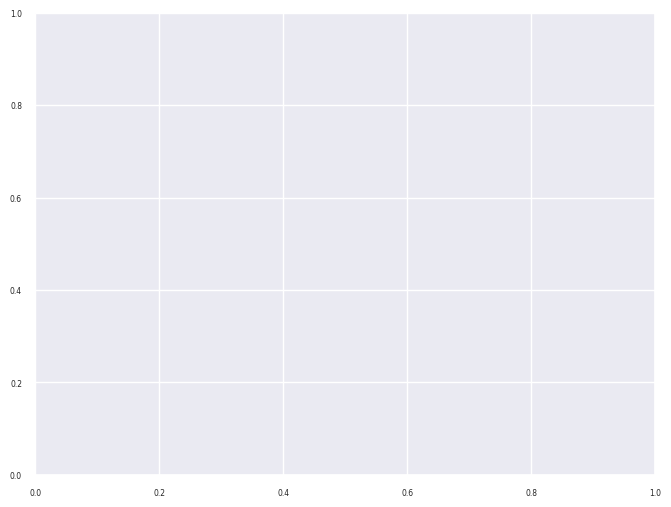

In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
best = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4, min_samples_split=75, splitter='best')

best.fit(X_train, Y_train)
y_pred = best.predict(X_test)
score = f1_score(Y_test, y_pred, average="weighted")
matrix = confusion_matrix(Y_test, y_pred, labels=["high", "low"])

print(score)
print(matrix)